In [1]:
#Reference :
#RandomForest
#https://github.com/apache/spark/blob/v2.2.0/mllib/src/main/scala/org/apache/spark/ml/classification/RandomForestClassifier.scala#L120
#One hot encoding
#https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
#LR from scratch
#https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac

In [1]:
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install --upgrade google-api-python-client
!pip install --upgrade seaborn
!pip install --upgrade networkx
!pip install --upgrade matplotlib
!pip install --upgrade pyspark
!pip install --upgrade pyspark_dist_explore


    100% |████████████████████████████████| 1.3MB 14.8MB/s ta 0:00:01
pyspark 2.3.1 requires py4j==0.10.7, which is not installed.
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (0.23.4)
    100% |████████████████████████████████| 61kB 4.0MB/s ta 0:00:011
    100% |████████████████████████████████| 71kB 9.3MB/s ta 0:00:011
    100% |████████████████████████████████| 215kB 33.7MB/s ta 0:00:01
    100% |████████████████████████████████| 1.7MB 17.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /root/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built networkx
    100% |████████████████████████████████| 12.9MB 2.9MB/s eta 0:00:01
  Found existing installation: matplotlib 3.0.1
    Uninstalling matplotlib-3.0.1:
      Successfully uninstalled matplotlib-3.0.

  Running setup.py bdist_wheel for pyspark ... done
  Stored in directory: /root/.cache/pip/wheels/cd/54/c2/abfcc942eddeaa7101228ebd6127a30dbdf903c72db4235b23
Successfully built pyspark
  Found existing installation: pyspark 2.3.1
    Can't uninstall 'pyspark'. No files were found to uninstall.


In [2]:
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import functions as F, types
import datetime
from pyspark.sql.functions import col, row_number, concat, lit
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import trim


In [3]:
%matplotlib inline


In [4]:
spark

In [5]:
sc = spark.sparkContext

In [6]:
sc.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.dir', 'hdfs://cluster-w261-m/user/spark/eventlog'),
 ('spark.ui.proxyBase', '/proxy/application_1544374336644_0001'),
 ('spark.driver.port', '42569'),
 ('spark.yarn.am.memory', '640m'),
 ('spark.executor.cores', '4'),
 ('spark.driver.appUIAddress',
  'http://cluster-w261-m.c.w266-203603.internal:4040'),
 ('spark.executor.instances', '2'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'cluster-w261-m'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.yarn.historyServer.address', 'cluster-w261-m:18080'),
 ('spark.driver.maxResultSize', '3840m'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.history.fs.logDirectory',
  'hdfs://cluster-w261-m/user/spark/eventlog'),
 ('spark.shuffle.service.enabled', 'true'),
 ('spark.scheduler.mode', 'FAIR'),
 ('sp

In [8]:
#https://blog.cloudera.com/blog/2015/03/how-to-tune-your-apache-spark-jobs-part-2/

#The number of cores can be specified with the --executor-cores flag when invoking 
#spark-submit, spark-shell, and pyspark from the command line, 
#or by setting the spark.executor.cores property in the spark-defaults.conf file 
#or on a SparkConf object.

#The cores property controls the number of concurrent tasks an executor can run. 
#--executor-cores 5 means that each executor can run a maximum of five tasks at the same time.

#The heap size can be controlled with the --executor-memory flag 
#or the spark.executor.memory property
#The memory property impacts the amount of data Spark can cache, 
#as well as the maximum sizes of the shuffle data structures used for grouping, aggregations, and joins.

#The --num-executors command-line flag or spark.executor.instances configuration property 
#control the number of executors requested. Starting in CDH 5.4/Spark 1.3, 
#you will be able to avoid setting this property by turning on dynamic allocation with the spark.dynamicAllocation.enabled property. Dynamic allocation enables a Spark application to request executors 
#when there is a backlog of pending tasks and free up executors when idle.


In [9]:
# spark.conf.set("spark.executor.memory", '19g')
# spark.conf.set('spark.executor.cores', '5')
# sc = spark.sparkContext


In [7]:
def f_calc_stats(data, column):
        return data.agg(F.avg(data[column]), F.min(data[column]), F.max(data[column]), \
                        F.stddev_pop(data[column]),F.var_pop(data[column]),F.skewness(data[column]) \
                       ).collect()

In [8]:
def f_check_null(data, column):
    return data.filter( (data[column] =="") |F.isnull(data[column])|F.isnan(data[column])
                      ).count()

In [15]:
#Checking cardinality
def f_display_stats_categ(df, inColList):
    dict1={}
    for col in inColList:
        cardinal_cnt = df.select([col]).distinct().count()
        dict1[col]={"Count_Unique_Vals":cardinal_cnt}
        dict1[col]['Count_Empty_String'] = str(df.filter(df[col] == "").count())

    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [41]:
def f_display_stats_int(data):
    dict1={}
    countTotal = data.count()
    for colname in [item[0] for item in data.dtypes if item[1].startswith('int')]:
        list1=f_calc_stats(data,colname)
        mean_val, min_val,max_val,stddev,var, skewness =list1[0]
        count_nulls = f_check_null(data,colname)
        dict1[colname]={}
        dict1[colname]['mean'] = str(round(mean_val,2))
        dict1[colname]['min'] = str(min_val)
        dict1[colname]['max'] = str(max_val)
        dict1[colname]['stddev'] = str(round(stddev,2))
        dict1[colname]['var'] = str(round(var,2))
        dict1[colname]['skewness'] = str(round(skewness,2))
        dict1[colname]['nulls_nans'] = str(count_nulls)
        dict1[colname]['pct_nulls_nans'] = str(round(float(count_nulls/countTotal*100),2))
        dict1[colname]['count_empty_string'] = str(data.filter(data[colname] == "").count())
        dict1[colname]['count_unique_values'] = str(data.select([colname]).distinct().count())
        dict1[colname]['count'] = 'N/A'
    dict1['TOTAL']={}
    dict1['TOTAL']['count'] = str(data.count())
   #Transposing dataframe to keep column names as rows
    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [17]:
#Create dataframe from RDD
def f_covert_to_df(rdd, col_list):
    return rdd.map(lambda x: x.split('\t')).toDF(col_list)

In [18]:
#Convert integer columns to IntegerType from String
def f_cast_str_to_int(df, integer_col_list):
    for col in integer_col_list:
        df = df.withColumn(col, df[col].cast(types.IntegerType()))
    return df

In [19]:
#Removing rows where at least one column has empty string
def f_remove_empty_string(df, categ_col_list):
    for categ_col in categ_col_list:
        df = df.filter(df[categ_col] != "")
        #df = df.filter(col(categ_col) != "")
    return df

In [89]:
#Converting categorical variables to one-hot encoding
def f_onehot_encoding(df,label_col_list, int_col_list, categ_col_list):
    stages=[]
    for categoricalCol in categ_col_list:
        stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#         encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
        encoder = OneHotEncoderEstimator(handleInvalid='keep', inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
        stages += [stringIndexer, encoder]
        
    #Skip for test data since test data does not have label
    if label_col_list is not None:
        labelColStr=''.join(label_col_list)
        label_stringIdx = StringIndexer(inputCol = labelColStr, outputCol = 'label')
        stages += [label_stringIdx]

    assemblerInputs = [c + "classVec" for c in categ_col_list] + int_col_list
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]

    cols = df.columns

#     partialPipeline = Pipeline(stages = stages)
    partialPipeline = Pipeline().setStages(stages)
    pipelineModel = partialPipeline.fit(df)

    preppedDataDF = pipelineModel.transform(df)

#     if label_col_list is not None:
#          selectedCols = ['label', 'features'] + cols
#     else:
#         selectedCols = ['features'] + cols
        
#     preppedDataDF = preppedDataDF.select(selectedCols)

    return preppedDataDF

In [21]:
trainRDD = sc.textFile('gs://bucket-w261-final/data/train.txt',50)
trainRDD.cache()

gs://bucket-w261-final/data/train.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [22]:
testRDD = sc.textFile('gs://bucket-w261-final/data/test.txt',50)
testRDD.cache()

gs://bucket-w261-final/data/test.txt MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0

In [23]:
labelColList=["clicked_0_1"]
intColList=["int_1", "int_2", "int_3", "int_4", "int_5", "int_6", "int_7", "int_8", "int_9", "int_10", "int_11", "int_12", "int_13"]
categColList=["categ_1", "categ_2", "categ_3", "categ_4", "categ_5", "categ_6", "categ_7", "categ_8", "categ_9", "categ_10", "categ_11", "categ_12", "categ_13", "categ_14", "categ_15", "categ_16", "categ_17", "categ_18", "categ_19", "categ_20", "categ_21", "categ_22", "categ_23", "categ_24", "categ_25", "categ_26"]


In [24]:
colList=[]
colList=labelColList+intColList+categColList
trainDF = f_covert_to_df(trainRDD,colList)
trainDF.cache()

DataFrame[clicked_0_1: string, int_1: string, int_2: string, int_3: string, int_4: string, int_5: string, int_6: string, int_7: string, int_8: string, int_9: string, int_10: string, int_11: string, int_12: string, int_13: string, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [25]:
colList=[]
colList=intColList+categColList
testDF = f_covert_to_df(testRDD,colList)
testDF.cache()

DataFrame[int_1: string, int_2: string, int_3: string, int_4: string, int_5: string, int_6: string, int_7: string, int_8: string, int_9: string, int_10: string, int_11: string, int_12: string, int_13: string, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [26]:
trainDF = f_cast_str_to_int(trainDF,intColList)
trainDF.cache()

DataFrame[clicked_0_1: string, int_1: int, int_2: int, int_3: int, int_4: int, int_5: int, int_6: int, int_7: int, int_8: int, int_9: int, int_10: int, int_11: int, int_12: int, int_13: int, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [27]:
testDF = f_cast_str_to_int(testDF,intColList)
testDF.cache()

DataFrame[int_1: int, int_2: int, int_3: int, int_4: int, int_5: int, int_6: int, int_7: int, int_8: int, int_9: int, int_10: int, int_11: int, int_12: int, int_13: int, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

## Toy Example

In [29]:
#Creating a subset for toy example
#intSubColList=["int_1","int_2"]
#categSubColList=["categ_1","categ_2"]
trainsubsetDF=trainDF.sample( withReplacement=True,fraction=0.0002,seed=1)
trainsubsetDF.cache()
trainsubsetDF.count()


9308

In [30]:
testsubsetDF=testDF.sample( withReplacement=True,fraction=0.0002,seed=1)
testsubsetDF.cache()
testsubsetDF.count()


1211

In [31]:
#Removing rows where at least one column has empty string
trainsubsetDF = trainsubsetDF.dropna()
testsubsetDF  = testsubsetDF.dropna()
trainsubsetDF= f_remove_empty_string(trainsubsetDF, categColList)
testsubsetDF= f_remove_empty_string(testsubsetDF, categColList)


In [32]:
trainsubsetDF.cache()
testsubsetDF.cache()


DataFrame[int_1: int, int_2: int, int_3: int, int_4: int, int_5: int, int_6: int, int_7: int, int_8: int, int_9: int, int_10: int, int_11: int, int_12: int, int_13: int, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [42]:
%%time
f_display_stats_int(trainsubsetDF)
f_display_stats_categ(trainsubsetDF, categColList)


,count,count_empty_string,count_unique_values,max,mean,min,nulls_nans,pct_nulls_nans,skewness,stddev,var
int_1,N/A,0,25,81,5.23,0,0,0.0,4.2,11.04,121.92
int_2,N/A,0,58,2468,90.07,-1,0,0.0,5.39,303.71,92239.0
int_3,N/A,0,49,244,22.44,1,0,0.0,3.5,31.95,1020.59
int_4,N/A,0,30,56,8.45,0,0,0.0,1.99,8.7,75.73
int_5,N/A,0,122,33255,1706.42,0,0,0.0,6.24,3408.72,11619382.82
int_6,N/A,0,82,889,68.93,0,0,0.0,3.98,131.79,17369.84
int_7,N/A,0,63,470,43.95,1,0,0.0,3.38,78.41,6147.44
int_8,N/A,0,46,49,18.57,0,0,0.0,0.67,14.38,206.78
int_9,N/A,0,122,2792,260.51,0,0,0.0,3.83,446.73,199564.0
int_10,N/A,0,4,3,0.64,0,0,0.0,1.19,0.74,0.54


,Count_Empty_String,Count_Unique_Vals
categ_1,0,27
categ_2,0,42
categ_3,0,131
categ_4,0,126
categ_5,0,12
categ_6,0,4
categ_7,0,104
categ_8,0,19
categ_9,0,2
categ_10,0,110


CPU times: user 1.19 s, sys: 764 ms, total: 1.95 s
Wall time: 19.8 s


In [90]:
trainOHEdf=f_onehot_encoding(trainsubsetDF, labelColList, intColList,categColList )
trainOHEdf.printSchema()

root
 |-- clicked_0_1: string (nullable = true)
 |-- int_1: integer (nullable = true)
 |-- int_2: integer (nullable = true)
 |-- int_3: integer (nullable = true)
 |-- int_4: integer (nullable = true)
 |-- int_5: integer (nullable = true)
 |-- int_6: integer (nullable = true)
 |-- int_7: integer (nullable = true)
 |-- int_8: integer (nullable = true)
 |-- int_9: integer (nullable = true)
 |-- int_10: integer (nullable = true)
 |-- int_11: integer (nullable = true)
 |-- int_12: integer (nullable = true)
 |-- int_13: integer (nullable = true)
 |-- categ_1: string (nullable = true)
 |-- categ_2: string (nullable = true)
 |-- categ_3: string (nullable = true)
 |-- categ_4: string (nullable = true)
 |-- categ_5: string (nullable = true)
 |-- categ_6: string (nullable = true)
 |-- categ_7: string (nullable = true)
 |-- categ_8: string (nullable = true)
 |-- categ_9: string (nullable = true)
 |-- categ_10: string (nullable = true)
 |-- categ_11: string (nullable = true)
 |-- categ_12: string (

In [91]:
testOHEdf=f_onehot_encoding(testsubsetDF, None, intColList,categColList )
testOHEdf.printSchema()

root
 |-- int_1: integer (nullable = true)
 |-- int_2: integer (nullable = true)
 |-- int_3: integer (nullable = true)
 |-- int_4: integer (nullable = true)
 |-- int_5: integer (nullable = true)
 |-- int_6: integer (nullable = true)
 |-- int_7: integer (nullable = true)
 |-- int_8: integer (nullable = true)
 |-- int_9: integer (nullable = true)
 |-- int_10: integer (nullable = true)
 |-- int_11: integer (nullable = true)
 |-- int_12: integer (nullable = true)
 |-- int_13: integer (nullable = true)
 |-- categ_1: string (nullable = true)
 |-- categ_2: string (nullable = true)
 |-- categ_3: string (nullable = true)
 |-- categ_4: string (nullable = true)
 |-- categ_5: string (nullable = true)
 |-- categ_6: string (nullable = true)
 |-- categ_7: string (nullable = true)
 |-- categ_8: string (nullable = true)
 |-- categ_9: string (nullable = true)
 |-- categ_10: string (nullable = true)
 |-- categ_11: string (nullable = true)
 |-- categ_12: string (nullable = true)
 |-- categ_13: string (nul

In [74]:
stringIndexerList = [StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index') for categoricalCol in categColList]

In [76]:
encoderList = [OneHotEncoderEstimator(handleInvalid='keep', inputCols=[stringIndexer.getOutputCol()], outputCols=[stringIndexer.getInputCol() + "classVec"]) for stringIndexer in stringIndexerList]

In [87]:
stages=[]
stages += [stringIndexerList]


In [79]:
labelColStr=''.join(labelColList)
label_stringIdx = StringIndexer(inputCol = labelColStr, outputCol = 'label')
stages += [label_stringIdx]


In [81]:
cols = trainsubsetDF.columns


In [85]:
partialPipeline = Pipeline.setStages(stages)
pipelineModel = partialPipeline.fit(trainsubsetDF)


TypeError: setStages() missing 1 required positional argument: 'value'

In [92]:
trainOHEdf.cache()
testOHEdf.cache()

DataFrame[int_1: int, int_2: int, int_3: int, int_4: int, int_5: int, int_6: int, int_7: int, int_8: int, int_9: int, int_10: int, int_11: int, int_12: int, int_13: int, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string, categ_1Index: double, categ_1classVec: vector, categ_2Index: double, categ_2classVec: vector, categ_3Index: double, categ_3classVec: vector, categ_4Index: double, categ_4classVec: vector, categ_5Index: double, categ_5classVec: vector, categ_6Index: double, categ_6classVec: vector, categ_7Index: double, categ_7classVec: vector, categ_8Index: double, categ_8classVec: vec

In [93]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(trainOHEdf)


In [109]:
??LogisticRegression

In [99]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testOHEdf)


In [106]:
', '.join(list(predictions.columns))

'int_1, int_2, int_3, int_4, int_5, int_6, int_7, int_8, int_9, int_10, int_11, int_12, int_13, categ_1, categ_2, categ_3, categ_4, categ_5, categ_6, categ_7, categ_8, categ_9, categ_10, categ_11, categ_12, categ_13, categ_14, categ_15, categ_16, categ_17, categ_18, categ_19, categ_20, categ_21, categ_22, categ_23, categ_24, categ_25, categ_26, categ_1Index, categ_1classVec, categ_2Index, categ_2classVec, categ_3Index, categ_3classVec, categ_4Index, categ_4classVec, categ_5Index, categ_5classVec, categ_6Index, categ_6classVec, categ_7Index, categ_7classVec, categ_8Index, categ_8classVec, categ_9Index, categ_9classVec, categ_10Index, categ_10classVec, categ_11Index, categ_11classVec, categ_12Index, categ_12classVec, categ_13Index, categ_13classVec, categ_14Index, categ_14classVec, categ_15Index, categ_15classVec, categ_16Index, categ_16classVec, categ_17Index, categ_17classVec, categ_18Index, categ_18classVec, categ_19Index, categ_19classVec, categ_20Index, categ_20classVec, categ_21Ind

In [108]:
predictions.select(['prediction']).show()

Py4JJavaError: An error occurred while calling o7831.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 784.0 failed 4 times, most recent failure: Lost task 3.3 in stage 784.0 (TID 46486, cluster-w261-w-5.c.w266-203603.internal, executor 16): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (vector) => vector)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 452, y.size = 1656
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:104)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:998)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:997)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1154)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:927)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:117)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:116)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:363)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3273)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3254)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3253)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2698)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (vector) => vector)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 452, y.size = 1656
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:104)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:998)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:997)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1154)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:927)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:117)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:116)
	... 19 more


In [98]:
trainOHEdf.show(5, truncate=False)

+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------+---------------+------------+---------------+------------+----------------+------------+-----------------+------------+---------------+------------+---------------+------------+----------------+------------+---------------+------------+---------------+-------------+----------------+-------------+----------------+-------------+----------------+-------------+----------------+-------------+----------------+-------------+----------------+-------------+-----------------+-------------+----------------+-------------+----------------+-------------+----------------+-------------+----------------+-------------+-----------------+-------------+----------------+-

In [226]:
predictions.show()

Py4JJavaError: An error occurred while calling o43048.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 3250.0 failed 4 times, most recent failure: Lost task 1.3 in stage 3250.0 (TID 228849, cluster-w261-w-6.c.w266-203603.internal, executor 16): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (vector) => vector)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 407, y.size = 1359
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:104)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:998)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:997)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1154)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:927)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:117)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:116)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:363)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3273)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3254)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3253)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2698)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (vector) => vector)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 407, y.size = 1359
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:104)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:998)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:997)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1154)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:927)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:117)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:116)
	... 19 more


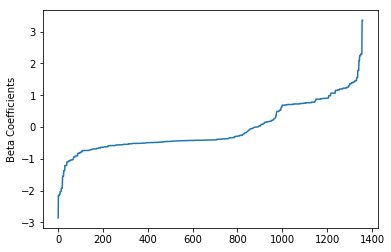

In [151]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()


In [203]:
predictions.columns

['int_1',
 'int_2',
 'int_3',
 'int_4',
 'int_5',
 'int_6',
 'int_7',
 'int_8',
 'int_9',
 'int_10',
 'int_11',
 'int_12',
 'int_13',
 'categ_1',
 'categ_2',
 'categ_3',
 'categ_4',
 'categ_5',
 'categ_6',
 'categ_7',
 'categ_8',
 'categ_9',
 'categ_10',
 'categ_11',
 'categ_12',
 'categ_13',
 'categ_14',
 'categ_15',
 'categ_16',
 'categ_17',
 'categ_18',
 'categ_19',
 'categ_20',
 'categ_21',
 'categ_22',
 'categ_23',
 'categ_24',
 'categ_25',
 'categ_26',
 'categ_1Index',
 'categ_1classVec',
 'categ_2Index',
 'categ_2classVec',
 'categ_3Index',
 'categ_3classVec',
 'categ_4Index',
 'categ_4classVec',
 'categ_5Index',
 'categ_5classVec',
 'categ_6Index',
 'categ_6classVec',
 'categ_7Index',
 'categ_7classVec',
 'categ_8Index',
 'categ_8classVec',
 'categ_9Index',
 'categ_9classVec',
 'categ_10Index',
 'categ_10classVec',
 'categ_11Index',
 'categ_11classVec',
 'categ_12Index',
 'categ_12classVec',
 'categ_13Index',
 'categ_13classVec',
 'categ_14Index',
 'categ_14classVec',
 'categ_1

In [204]:
predictions.select(['probability']).show(30)

Py4JJavaError: An error occurred while calling o37672.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 3091.0 failed 4 times, most recent failure: Lost task 1.3 in stage 3091.0 (TID 219957, cluster-w261-w-6.c.w266-203603.internal, executor 16): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (vector) => vector)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 407, y.size = 1359
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:104)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:998)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:997)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1154)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:927)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:117)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:116)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:363)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3273)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3254)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3253)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2484)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2698)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (vector) => vector)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 407, y.size = 1359
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:104)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:998)
	at org.apache.spark.ml.classification.LogisticRegressionModel$$anonfun$33.apply(LogisticRegression.scala:997)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1154)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:927)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:117)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel$$anonfun$1.apply(ProbabilisticClassifier.scala:116)
	... 19 more


In [159]:
# View model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well. For example's sake we will choose age & occupation
selected = predictions.select(["int_1", "categ_1", "categ_2", "categ_9"])
print(selected)

DataFrame[int_1: int, categ_1: string, categ_2: string, categ_9: string]


In [135]:
trainingSummary = lrModel.summary
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)


objectiveHistory:
0.6246435805602668
0.06516424656674812
0.03360207136478358
0.01957540415658673
0.009286072224274078
0.004150578329405111
0.0025272688370632226
0.0012222793897761512
0.0006214570303035642
0.00029553695259758653
0.00015151508917908565


In [138]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())


In [139]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainSubsetOHEdf)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing


NameError: name 'evaluator' is not defined

In [ ]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)


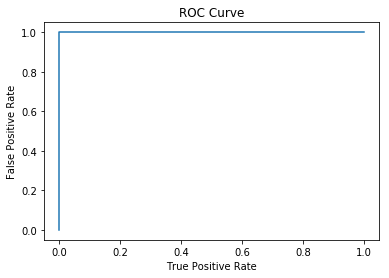

Training set areaUnderROC: 0.9999999999999999


In [119]:
#ROC curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [113]:
predictions = lrModel.transform(testsubsetDF)


In [114]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))


IllegalArgumentException: 'Field "label" does not exist.\nAvailable fields: features, int_1, int_2, int_3, int_4, int_5, int_6, int_7, int_8, int_9, int_10, int_11, int_12, int_13, categ_1, categ_2, categ_3, categ_4, categ_5, categ_6, categ_7, categ_8, categ_9, categ_10, categ_11, categ_12, categ_13, categ_14, categ_15, categ_16, categ_17, categ_18, categ_19, categ_20, categ_21, categ_22, categ_23, categ_24, categ_25, categ_26, rawPrediction, probability, prediction'

### Checking stats for columns

In [ ]:
# Let's look at some of the data in histograms
# def plot_hist(hist_list):
#     pd.DataFrame(
#         list(zip(*hist_list)), 
#         columns=['bin', 'frequency']
#     ).set_index(
#         'bin'
#     ).plot(kind='bar');

In [ ]:
# temp_hist = trainDF.select('int_1_log').rdd.flatMap(lambda x: x).histogram(20)


In [ ]:
# plot_hist(temp_hist)


In [ ]:
# tempDF = trainDF.select(["int_1"]).collect()


In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=1)
# fig.set_size_inches(5, 5)
# hist(axes, x=tempDF)

